In [6]:
import torch_geometric
from data.ruijin import RuijinBags
from torchvision import transforms
from data.PatientBags import PatientBags

In [8]:
root = '/remote-home/my/Ultrasound_CV/data/MergePhase1/test_0.3'
pre_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])
test_set = PatientBags(root+'/test',pre_transform=pre_transform,mix_mode=0)
test_bag = test_set[0][0]
print(test_bag.shape)


torch.Size([6, 64, 3, 28, 28])


In [9]:
instance1 = test_bag[0,:,:,:]
print(instance1.shape)

torch.Size([64, 3, 28, 28])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.ResNet import ResNet10

In [29]:
class graph(nn.Module):
    def __init__(self,input_dim=3,L=500,D=128,K=1):
        super(graph,self).__init__()
        self.input_dim = input_dim
        self.L = L
        self.D = D
        self.K = K
        
        self.feature_extractor_part1 = ResNet10()
        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(512*1*1,self.L),
            nn.ReLU()
        )
    
    def forward(self,x):
        x = x.view(-1,3,28,28)
        print(x.shape)
        f1 = self.feature_extractor_part1(x)
        f1 = f1.view(-1,512*1*1)
        print(f1.shape)
        f2 = self.feature_extractor_part2(f1)
        print(f2.shape)
        return f2
        

In [31]:
tst  = graph().forward(instance1)
patch = tst.view(8,8,500)
print(patch.shape)

torch.Size([64, 3, 28, 28])
torch.Size([64, 512])
torch.Size([64, 500])
torch.Size([8, 8, 500])


In [33]:
sim_matrix = torch.zeros(64,64)
for i in range (64):
    for j in range (64):
        sim_matrix[i][j] = torch.cosine_similarity(tst[i,:],tst[j,:],dim=0)

In [34]:
print(sim_matrix)

tensor([[1.0000, 0.5031, 0.5169,  ..., 0.3457, 0.4141, 0.3925],
        [0.5031, 1.0000, 0.5102,  ..., 0.3870, 0.3822, 0.4345],
        [0.5169, 0.5102, 1.0000,  ..., 0.3574, 0.4103, 0.4219],
        ...,
        [0.3457, 0.3870, 0.3574,  ..., 1.0000, 0.4023, 0.5024],
        [0.4141, 0.3822, 0.4103,  ..., 0.4023, 1.0000, 0.4407],
        [0.3925, 0.4345, 0.4219,  ..., 0.5024, 0.4407, 1.0000]],
       grad_fn=<CopySlices>)


In [39]:
import numpy as np
pos_matrix = np.zeros((8,8),int)
for i in range(8):
    for j in range(8):
        pos_matrix[i][j] = int(8*i+j) 
print(pos_matrix)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


In [83]:
cb_matrix = np.zeros((64,64),int)
for i in range(64):
    for j in range(i+1,64):
        x1 = np.floor(i/8)
        y1 = i%8
        x2 = np.floor(j/8)
        y2 = j%8
        cb_matrix[i][j] = cb_matrix[j][i] = int(abs(x1-x2)+abs(y1-y2))
print(cb_matrix)
np.savetxt('dist.txt',cb_matrix)

[[ 0  1  2 ... 12 13 14]
 [ 1  0  1 ... 11 12 13]
 [ 2  1  0 ... 10 11 12]
 ...
 [12 11 10 ...  0  1  2]
 [13 12 11 ...  1  0  1]
 [14 13 12 ...  2  1  0]]


In [89]:
edge_matrix = torch.zeros(64,64)
for i in range(64):
    for j in range (i+1,64):
        edge_matrix[i][j] = edge_matrix[j][i] = sim_matrix[i][j]/(cb_matrix[i][j]**0.5)
print(edge_matrix)

tensor([[0.0000, 0.5031, 0.3655,  ..., 0.0998, 0.1149, 0.1049],
        [0.5031, 0.0000, 0.5102,  ..., 0.1167, 0.1103, 0.1205],
        [0.3655, 0.5102, 0.0000,  ..., 0.1130, 0.1237, 0.1218],
        ...,
        [0.0998, 0.1167, 0.1130,  ..., 0.0000, 0.4023, 0.3552],
        [0.1149, 0.1103, 0.1237,  ..., 0.4023, 0.0000, 0.4407],
        [0.1049, 0.1205, 0.1218,  ..., 0.3552, 0.4407, 0.0000]],
       grad_fn=<CopySlices>)


In [90]:
threshold = torch.max(edge_matrix)
print(threshold)
edge = edge_matrix > 0.5*threshold
a = np.array(edge).astype(int)
print(a)

tensor(0.6795, grad_fn=<MaxBackward1>)
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [94]:
coo = []
for i in range (64):
    for j in range(i+1,64):
        if a[i][j]== 1:
            coo.append([i,j])

print(coo)
coo = np.array(coo,int)
coo = coo.T
print(type(coo))

[[0, 1], [0, 2], [0, 8], [0, 9], [0, 16], [1, 2], [1, 3], [1, 8], [1, 9], [1, 16], [2, 3], [2, 9], [2, 10], [3, 4], [3, 10], [3, 11], [4, 5], [4, 12], [4, 13], [5, 6], [6, 7], [6, 14], [7, 15], [8, 9], [8, 16], [9, 10], [9, 16], [9, 17], [9, 25], [10, 17], [10, 18], [11, 12], [11, 18], [11, 19], [12, 13], [12, 20], [13, 14], [13, 21], [13, 22], [14, 15], [15, 23], [16, 17], [16, 24], [16, 25], [17, 18], [17, 24], [17, 25], [18, 19], [18, 26], [19, 20], [19, 21], [19, 27], [19, 28], [20, 21], [20, 27], [20, 28], [21, 22], [21, 28], [21, 29], [22, 30], [23, 31], [24, 25], [24, 32], [25, 26], [25, 33], [26, 27], [26, 33], [26, 34], [27, 28], [27, 35], [28, 29], [28, 35], [28, 36], [29, 30], [29, 37], [30, 31], [30, 38], [31, 38], [31, 39], [32, 33], [32, 40], [32, 41], [33, 34], [33, 41], [33, 49], [34, 35], [34, 36], [34, 42], [35, 36], [35, 43], [36, 37], [36, 43], [36, 44], [37, 38], [37, 45], [38, 39], [38, 46], [39, 46], [39, 47], [40, 41], [40, 48], [41, 42], [41, 49], [41, 50], [42

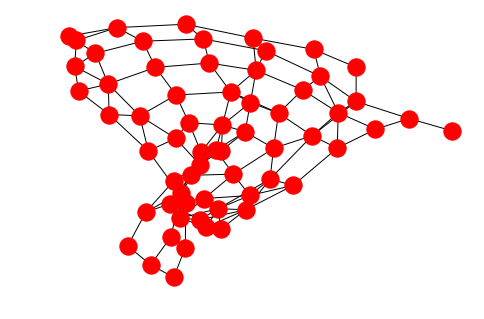

In [92]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
 
G = nx.Graph()
for i in range (64):
    for j in range (64):
        if a[i][j]:
            G.add_edge(i, j)
nx.draw(G)
plt.show()
